# 16.413 Final Project: Convex Risk Bounded Continuous-Time Trajectory Planning for a Europa Lander

Julia Briden (jbriden@mit.edu)
Kota Kondo (kkondo@mit.edu)
Lakshay Sharma (lakshays@mit.edu)
Nick Rober (nrober@mit.edu)
Youngjae Min (youngj0@mit.edu)

## 1. Problem Statement

The year is 2048 and alien life has been detected under the ice of Europa! In the interest of getting to know our newly discovered neighbors, NASA has decided to dispatch a highly specialized fleet of vehicles to the Gallilean moon. The mission will consist of (i) an autonomous underwater vehicle (AUV) designed to slowly glide to Europa's sea floor while transmitting data via an optical fiber cable to a rover on the surface, (ii) a surface rover designed to ferry the underwater vehicle from a safe landing site to an appropriate insertion site (i.e. vapor plume outburst location), and (iii) an orbiter, capable of relaying signals from the rover and providing high-resolution imagery to map the surface.

![alt text](environment_basic.jpg "Europa Lander mission concept")

As part of NASA's Jet Propulsion Laboratory, our team has been tasked with creating the trajectory generation algorithm for the surface vehicle. The goal for the rover is to navigate from a safe landing site which is flat and free of obstacles to the AUV's insertion point, which has relatively thin ice and may be surrounded by uncertain hazards. We have access to global map data within the field of operation, allowing us to formulate the trajectory generation problem as an infinite horizon mixed-integer nonlinear programming problem. We will solve this optimization problem using scipy.minimize and the Bernstein polynomial library BEBOT. To provide additional autonomy capabilities and give the optimization algorithm a good chance of finding a feasible solution, we will initilize the optimizer using RRT* to form an initial guess of the optimal trajectory.

### Formulation

Generally, this problem can be stated as an optimal control problem in the form of

***
<font size="3"><h1><center>$\underset{x(t)\in\mathbb{R}^{n_x},\;u(t)\in\mathbb{R}^{u_n}}{\text{minimize}}\quad E(x(0),\;x(1))+\int_{0}^{1}F(x(t),u(t))dt$ <div style="text-align: right"> (1) </div><br> $\begin{align} & \text{subject to} \quad \quad \\  \\ &\dot{x} = f(x(t),\;u(t)),\quad \forall t\in[0,1] \\ & e(x(0),\;x(1)) = 0, \\ & h(x(t),\;u(t)) \leq 0,\quad \forall t\in[0,1] \end{align}$</center></h1></font>
***

However, this is a difficult problem to solve. We can simplify it by considering that our system can be modelled using the common unicycle model:

***
<font size="3"><h1><center>$\dot{x} = \begin{bmatrix} \dot{x}_1 \\ \dot{x}_2 \\ \dot{\phi} \end{bmatrix} = \begin{bmatrix} V \cos(\phi) \\ V \sin(\phi) \\ \omega \end{bmatrix}$</center></h1></font>
***

which is differentially flat. In this case, that is helpful because it means we can determine the inputs $V$ and $\omega$ directly from $x_1$ and $x_2$. Additionally, we can approximate $x(t)$ (the optimal trajectory) using a  Bernstein polynomial, which takes the form 

***
<font size="3"><h1><center>$x_N(t) = \sum_{i=0}^N \bar{x}_{i,N}b_{i,N}(t)$</center></h1></font>
***

where $\bar{x}_N = [\bar{x}_{0,N},\; ...,\; \bar{x}_{N,N}] \in \mathbb{R}^{n_x \times (N+1)}$, is a vector of control points for the Bernstein polynomial and 

***
<font size="3"><h1><center>$b_{i,N}(t) = \begin{pmatrix}N \\ i\end{pmatrix}t^i(1-t)^{N-i},\quad \begin{pmatrix}N \\ i\end{pmatrix} = \frac{N!}{i!(N-i)!}$</center></h1></font>
***

The use of Bernstein polynomials allows us to formulate the problem as a finite-dimensional optimization problem (choose N control points), rather than an infinite dimensional optimization problem. Additionally, Bernstein polynomials are fixed at the endpoints, (i.e. $x_N(t_0) = \bar{x}_{0,N}$ and $x_N(t_f) = \bar{x}_{N,N}$, allowing us to remove the equality constraint from (1). The fact that the model is differentially flat allows us to remove $u(t)$, and the convex hull property of Bernstein polynomials allows us to only evaluate the control points $\{x_{0,N}, ..., x_{N,N}\}$ for satisfaction of the inequality constraints. Thus, the simplified problem becomes

***
<font size="3"><h1><center>$\underset{\bar{x}_N}{\text{minimize}}\quad E(\bar{x}_{0,N},\;\bar{x}_{N,N})+\int_{0}^{1}F(x_N(t))dt$ <div style="text-align: right"> (2) </div><br> $\begin{align} & \text{subject to} \quad & \quad \\ & \|\dot{x}_N(t_i) - f(x_N(t_i)\| \leq 0, & \forall i \in \{0, 1, ..., N\} \\ & h(\bar{x}_{i,N}) \leq 0, & \forall i \in \{0, 1, ..., N\} \end{align}$</center></h1></font>
***

Finally, to address the inequality constraints $h(\bar{x}_{i,N})$, we list the necessary constraints on the system as

- Collision avoidance constraints (addressed below)
- Maximum and minimum speed constraints
- Maximum and minimum angular rate constraints

and plan to use total path length as the cost function to minimize the distance required by the rover to travel to the AUV insertion point.


From a practical standpoint, the scipy function minimize() can be used to solve problem (2). However, it requires an initial guess of the optimal trajectory as a starting point from which to begin using gradient descent. This guess warrants some consideration as it can have a large influence on the output of the function: one initial guess may give a good answer, while another may give local minima or even fail to converge to a solution. One option to generate this initial guess is to linearly interpolate between the initial and final positions. However it is often beneficial to give an initial guess which satisfies the system's constraints, which may not be the case if an obstacle lies on the straightline path between the initial and final positions. Thus, we plan to use RRT* as a fast way to generate what is hopefully a good initial guess.

Source: https://arxiv.org/pdf/1812.06132.pdf




## 2. Risk Contours

Risk contours are defined as the set of all points in uncertain environments with guaranteed bounded risk. We will use risk contours in finding optimal trajectories. 

For simplicity we incorporate only static risk contours into our problem, not dynamic contours, and replace probabilistic constraint with deterministic constraint in terms of x (use inner approximation of probabilisitic constraint to bound risk), which lead to rational polynomial representation.

### How to construct risk contours

Define $\chi \in \mathbb{R}^2$ as an uncertain environment where our ground robot explores and $\chi_{obs_{i}}(\omega_i) \subset \chi$, for $i = 1, ..., n_{o_{s}}$ as static uncertain obstacles, where $n_{o_{s}}$ is the number of static obstacles, $\omega_i$ is a probablistic uncertain parameters. 

Then, we can represent $\chi_{obs_{i}}(\omega_i)$ in terms of polynomials in x $\in \chi$

***
$\chi_{obs_{i}}(\omega_i) \equiv \{x \in \chi | P_i(x, \omega_i) \geq 0\}$ for i = 1, ..., $n_{o_{s}}$ (1)
***

where P_i : $\mathbb{R}^{n_x + n_{\omega}} \to \mathbb{R}$ denotes a given polynomial. Let $\triangle \in [0, 1]$ be a given acceptable risk level, and then, $C^{\triangle}_{r}$, static risk contour whose risk level, with less than the given acceptable can be defined as

***
$C^{\triangle}_{r} \equiv \{x \in \chi | Prob(x \in \chi_{obs}(\omega)) \leq \triangle\}$ (2)
***

By this definition, static risk contour is now defined with a deterministic constraint in terms of x. Furthermore, the static risk contour's inner approximation is given as

***
$\hat{C}^{\triangle}_{r} \equiv \{x  \in \chi | \frac{\mathbb{E}[P^2(x, \omega)] - \mathbb{E}[P(x, \omega)]^2}{\mathbb{E}[P^2(x, \omega)]} \leq \triangle  or  \mathbb{E}[P(x, \omega)] \leq 0 \}$ (3)
***

Since $\hat{C}^{\triangle}_{r}$ is an approximation of inner space of $C^{\triangle}_{r}$, any trajectory going through $\hat{C}^{\triangle}_{r}$ has a risk less or equal to the given $\triangle$.

*Convex Risk Bounded Continuous-Time Trajectory Planning in Uncertain Nonconvex Environments (https://arxiv.org/pdf/2106.05489.pdf)* gives a good expample to illustrate the use of this risk contour generation method.

### Function outline for generating random obstacles in the environment

In [25]:
## Function definition
#
# input
#    env: environment size [x1, y1, x2, y2]
#    shape: obstacle shape options (eg. circle, rectangle, etc)
#.   max_size: maximum obstacle size [x_max, y_max]
#    omega_range: range of potential probablistic uncertain parameters [min, max]
#
# output
#    pols: a list of polynomials that represents an obstacle, including probabilistic uncertain parameter, omega
#

def random_ob(env, shape, max_size, omega_range):
    # randomly generate obstacles within the given environments
    # return a list of polynomials generated according to the given shape, maximum size, and omega range
    return pols

### Function outline for static risk contours 

In [26]:
## Function definition
#
# input
#    delta: acceptable risk level, [0,1]
#    pol: polynomial that represents an obstacle, including probabilistic uncertain parameter, omega  
#
# output
#    C: the boundary of inner approximation of risk contour, which is denoted as a polynomial
#

def static_rc(delta, pol):
    # calculate C using equation (3)
    # need to calculate expected values using the given polynomials
    # since delta is given, we can find the boundary of C as a form of a polynomial
    # may need another function to convert the given polynomial to another form. 
    return C

## 3. Continuous-Time Risk Bounded Trajectory Planning using Risk Contours


From part 2, we have formulated conditions for a point $x$ in a trajectory to be safe with the maximum risk of $\Delta$ to collide with uncertain static obstacles as below.

***
$\frac{\mathbb{E}[P^2(x, \omega)] - \mathbb{E}[P(x, \omega)]^2}{\mathbb{E}[P^2(x, \omega)]} \leq \Delta  \land  \mathbb{E}[P(x, \omega)] \leq 0 \$
***

With known momentums of $\omega$, the conditions are polynomial in $x$, and then the feasible set for the trajectory optimization problem can be presented as

***
$\mathcal{S}=\{x: g_i(x) \geq 0 \;\; i=1,\dots,l\}$
***

for some polynomials $g_i$. We are using RRT to find a trajectory in this feasible set to reach the goal state from the initial state. For RRT, we have to define two important functions STEER and ObstacleFree.

### Steer

Given a sampled point and the current state of the RRT tree, steer() finds the node in the RRT tree nearest to the sampled point, and generates a path from that node towards the sampled point (not necessarily ending at the sampled point) in the form of

***
$x(t) = \sum_{i=0}^d c_i t^i \;\; t \in [t_1, t_2]$
***

This path is added as an edge and the endpoint of this path is added as a new node to the RRT tree.



In [ ]:
## Function definition
#
# input
#    tree: current RRT tree
#    endpoint: sampled point towards which the RRT tree needs to grow
#    env: environment representation, including obstacles 
#
# output
#    extended_path: parameters for the extended path
#

def steer(tree, endpoint, env):
    return extended_path

### ObstacleFree

To check the safety of the path defined above, one can use SOS-based continuous-time technique by checking whether each polynomial $g_i(x(t))$ can be represented with SOS polynomials as

***
$g_i(x(t)) = \sigma_{0i}(t) + \sigma_{1i}(t)(t-t_1) + \sigma_{2i}(t)(t_2-t)$
***

where $\sigma_{0i}(t), \sigma_{1i}(t), \sigma_{2i}(t)$ are SOS polynomials. This can be checked using Yalmip and Spotless packages, but for simplicity, we employ an apporximate collision-checking method.

We sample points along the extended path, and check for each point whether it resides in $\mathcal{S}$. By sampling densely enough, we can approximately check if the exented path is free from collision with obstacles.

In [ ]:
## Function definition
#
# input
#    x_nearest: the point closest to x_new
#    x_new: randomly chosen point by RRT
#    env: environment variable used for collision checking
#    radius: the robot radius
#    safety_factor: extra buffering region around the robot
#
# output
#    boolean: True if the temporary trajectory that steer() function generates hits obstacles, otherwise False.
#

def obstacle_free(x_nearest, x_new, env, radius, safety_factor): 
    # check if the newly generated line from x_nearest to x_new is violating the obstacle constraints.
    # put extra buffer around the line and check collisions using the given obstacles by env
    return boolean

### RRT* for trajectory generation

Then, using the functions defined above, we can employ RRT* to generate a trajectory with bounded risk $\Delta$ to collide with uncertain static obstacles.

In [ ]:
from polynomial.bernstein import Bernstein

In [ ]:
## Function definition
#
# input
#    init: initial sate of the robot
#    goal: goal state of the robot
#    env: environment representation, including obstacles
#    radius: the robot radius
#    safety_factor: extra buffering region around the robot
#
# output
#    trajectory: list of successvie paths represented with parameters
#

def generate_trajectory(init, goal, env, radius, safety_factor):
    return trajectory

## Functions for Optimization

As mentioned previously, we will be using the scipy library function *minimize* to solve the problem given by Eq. 2 in Section 1. The use of this function requires the use of two support functions, namely a cost function *cost(xN)* which determines the cost of a given trajectory, and *nonlcon(xN, params)* which checks that the trajectory satisfies the constraints of the problem. The function stubs for these two functions, as well as the main optimization function are summarized below:

In [ ]:
# Parameters for the current optimization problem.
class Parameters:
    def __init__(self, obstacles):
        self.deg = 7    # Degree of Bernstein polynomials being used
        self.tf = 30.0  # Final time. Note that the initial time is assumed 0
        self.dsafe = 1  # Minimum safe distance between vehicle and obstacles
        self.vmax = 10  # Maximum speed
        self.wmax = 3*np.pi/2 # Maximum angular rate
        self.riskmax = 0

        self.pos0 = [0,0] # Initial position
        self.speed0 = 0 # Initial speed
        self.psi0 = np.pi/4 # Initial heading angle

        # Final points
        self.posf = [10,10]
        self.speed0 = 0 # Final speeds
        self.psis0 = np.pi/2 # Final heading angles

        # Obstacle positions
        # self.obstacles =         

In [9]:
import pdb
import numpy as np
def reform(vector):
    N = int((len(vector)-1)/2)
    x = vector[0:N]
    y = vector[N:-1]
    # pdb.set_trace()
    ctrps = np.vstack((x, y))
    tf = vector[-1]
    return ctrps, tf

# opt_vec = np.array([1., 2., 1., 1., 0., 3., 0., 0., 10.])
# opt_ctrps, tf = reform(opt_vec)
# # pdb.set_trace()
# print(opt_ctrps[:,1])
# print(tf)

[2. 3.]
10.0


In [54]:
from polynomial.bernstein import Bernstein
## Function definition
#
# input
#    xN: set of control points being optimized
#
# output
#    cost: the cost value of the control points given by the input
#

def cost(opt_vec): 
    xN, tf = reform(opt_vec)
    dist_sum = 0.0
    num_points = xN.shape[1]
    
    
    for i in range(num_points-1):
        dist = np.sqrt((xN[0][i]-xN[0][i+1])**2+(xN[1][i]-xN[1][i+1])**2)
        dist_sum += dist
    return dist_sum

opt_vec = np.array([0., 1., 2., 3., 0., 0., 0., 0., 10.])
opt_ctrps, tf = reform(opt_vec)

elev = 10
bp = Bernstein(opt_ctrps, tf=10)

speed = bp.diff().normSquare().elev(5).cpts.flatten()

bpdot = bp.diff()
bpddot = bpdot.diff()

xdot = bpdot.x
ydot = bpdot.y
xddot = bpddot.x
yddot = bpddot.y

num = yddot*xdot - xddot*ydot
den = xdot*xdot + ydot*ydot

cpts = num.elev(elev).cpts / den.elev(elev).cpts




print(bp)
print(speed)
print(cpts.flatten())

Bernstein([[0. 1. 2. 3.]
 [0. 0. 0. 0.]], 0.0, 10.0)
[0.09 0.09 0.09 0.09 0.09 0.09 0.09 0.09 0.09 0.09 0.09 0.09]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
## Function definition
#
# input
#    xN: set of control points being optimized
#    params: parameters of the problem. This will include start and end points, information on obstacles and the
#            environment, min allowable distance to obstacles, max and min velocity, max and min angular velocity
#
# output
#    constraints: a vector of the constrained variables associated with the problem. Must be >=0 to be satisfied
#

def nonlcon(opt_vec, params): 
    # derive velocity, angular velocity, and distance to obstacles based on xN
    # constraints = [params.max_vel-vel, vel-params.min_vel, params.max_ang_vel-ang_vel, ang_vel-params.min_ang_vel,
    #                dist-min_dist]
    xN, tf = reform(opt_vec)
    degree_elevation = params.degree_elevation
    
    
    bp = Bernstein(xN, tf=tf)
    
    speed = bp.diff().normSquare().elev(degree_elevation).cpts.flatten() # Bernstein polynomial representing speed

    bpdot = bp.diff()
    bpddot = bpdot.diff()

    xdot = bpdot.x
    ydot = bpdot.y
    xddot = bpddot.x
    yddot = bpddot.y

    num = yddot*xdot - xddot*ydot
    den = xdot*xdot + ydot*ydot

    wN = num.elev().cpts / den.elev(elev).cpts
    wN = wN.squeeze() # Bernstein polynomial representing angular rate
    
    # Obstacles:
    
    
    
    
    return constraints

In [ ]:
## Function definition
#
# input
#    x0: initial guess of control points created by generate_trajectory
#    params: parameters of the problem. This will include start and end points, information on obstacles and the
#            environment, min allowable distance to obstacles, max and min velocity, max and min angular velocity
#
# output
#    xN_opt: set of control points representing the Bernstein polynomial approximation to the optimal trajectory
#

def generate_optimal_trajectory(x0, params): 
    # Use minimize function to generate an approximation to the optimal trajectory:
    # xN_opt = minimize(@(x)cost(x),x0,@(x)nonlcon(x,params))
    return xN_opt

  NIT    FC           OBJFUN            GNORM
    1    26     1.023203E+02     1.907349E-06
    2    52     1.367379E+02     3.952428E+00
    3    78     2.776713E+02     5.370523E+00
    4   104     3.508149E+02     6.139669E+00
    5   130     2.908377E+02     5.758303E+00
    6   156     2.709587E+02     5.703338E+00
    7   182     2.601297E+02     6.030704E+00
    8   208     2.475325E+02     5.063203E+00
    9   234     2.436559E+02     5.268989E+00
   10   260     2.415504E+02     5.292737E+00
   11   286     2.359184E+02     5.408139E+00
   12   312     2.345304E+02     5.914655E+00
   13   338     2.243162E+02     5.235679E+00
   14   364     1.958134E+02     4.960107E+00
   15   390     1.490686E+02     4.621493E+00
   16   416     1.379126E+02     4.363060E+00
   17   442     1.250877E+02     4.210017E+00
   18   468     1.162114E+02     3.635885E+00
   19   496     1.156662E+02     2.922884E+00
   20   522     1.149245E+02     2.833978E+00
   21   548     1.138310E+02     2

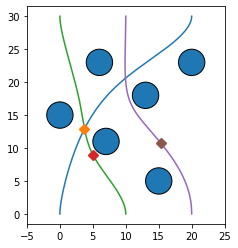

In [44]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon May 18 13:48:10 2020

@author: ckielasjensen
"""

import matplotlib.pyplot as plt
from numba import njit
import numpy as np
from scipy.optimize import minimize, Bounds

from optimization.AngularRate import angularRate
from optimization.ObstacleAvoidance import obstacleAvoidance
from optimization.Speed import speed
from optimization.TemporalSeparation import temporalSeparation
from polynomial.bernstein import Bernstein


def initGuess(params):
    """
    Initial guess for the optimizer.

    We use a straight line guess from the second control point to the second to
    last control point. This is because the first and last control points are
    defined by the initial and final positions and the second and second to
    last control points are defined by the initial and final points along with
    the initial and final speeds and angles.

    The initial guess vector is laid out as follows:
        [x_{1, 2}, ..., x_{1, n-2}, y_{1, 2}, ..., y_{1, n-2}, x_{2, 2}, ...,
         y_{2, n-2}, ..., x_{v, 2}, ..., y_{v, n-2}]
    Where x_{1, 2} is the second X control point of the first vehicle, n is the
    degree of polynomials being used, and v is the number of vehicles.

    Parameters
    ----------
    params : Parameters
        Class containing the parameters of the problem.

    Returns
    -------
    numpy.array
        1D vectory containing the initial guess for the optimizer. See above
        description for the layout of the vector.

    """
    x0 = []
    for i in range(params.nveh):
        inimag = params.inispeeds[i]*params.tf/params.deg
        finalmag = params.finalspeeds[i]*params.tf/params.deg

        x1 = params.inipts[i, 0] + inimag*np.cos(params.inipsis[i])
        y1 = params.inipts[i, 1] + inimag*np.sin(params.inipsis[i])

        xn_1 = params.finalpts[i, 0] - finalmag*np.cos(params.finalpsis[i])
        yn_1 = params.finalpts[i, 1] - finalmag*np.sin(params.finalpsis[i])

        x0.append(np.linspace(x1, xn_1, params.deg-1)[1:-1])
        x0.append(np.linspace(y1, yn_1, params.deg-1)[1:-1])

    return np.concatenate(x0)


@njit(cache=True)
def reshape(x, deg, nveh, tf, inipts, finalpts, inispeeds, finalspeeds,
            inipsis, finalpsis):
    """
    Reshapes the optimization vector X to a usable matrix for computing the
    cost and constraints.

    By keeping certain values constant, such as the initial and final
    positions, the reshape command can effectively be used to guarantee
    equality constraints are met without increasing the computational
    complexity of the optimization.

    See initGuess for the format of the x vector.

    The resulting y matrix is of the following format:
        [[x_{1, 0}, ..., x_{1, n}],
         [y_{1, 0}, ..., y_{1, n}],
         [x_{2, 0}, ..., x_{2, n}],
         [y_{2, 0}, ..., y_{2, n}],
         ...
         [x_{v, 0}, ..., x_{v, n}],
         [y_{v, 0}, ..., y_{v, n}]]
    Where x_{1, 0} is the 0th control point of the first vehicle in the X
    dimension, n is the degree of the polynomials being used, and v is the
    number of vehicles.

    Parameters
    ----------
    x : numpy.array
        Optimization vector to be reshaped.
    deg : int
        Degree of the polynomials being used.
    nveh : int
        Number of vehicles.
    tf : float
        Final time of the mission. Assuming initial time is 0.
    inipts : numpy.array
        Initial points of each vehicle where the rows correspond to the
        vehicles and the columns correspond to the X and Y positions (i.e.
        column 0 is the X column and column 1 is the Y column).
    finalpts : numpy.array
        Final points of each vehicle. Same format as inipts.
    inispeeds : numpy.array
        Initial speeds of each vehicle. Each entry corresponds to a vehicle.
    finalspeeds : numpy.array
        Final speeds of each vehicle. Each entry corresponds to a vehicle.
    inipsis : numpy.array
        Initial heading angles of each vehicle. Each entry corresponds to a
        vehicle.
    finalpsis : numpy.array
        Final heading angles of each vehicle. Each entry corresponds to a
        vehicle.

    Returns
    -------
    y : numpy.array
        Reshaped optimization vector. See above description for more info.

    """
    y = np.empty((2*nveh, deg+1))

    y[0::2, 0] = inipts[:, 0]
    y[1::2, 0] = inipts[:, 1]
    y[0::2, -1] = finalpts[:, 0]
    y[1::2, -1] = finalpts[:, 1]

    inimags = inispeeds*tf/deg
    finalmags = finalspeeds*tf/deg

    y[0::2, 1] = inipts[:, 0] + inimags*np.cos(inipsis)
    y[1::2, 1] = inipts[:, 1] + inimags*np.sin(inipsis)
    y[0::2, -2] = finalpts[:, 0] - finalmags*np.cos(finalpsis)
    y[1::2, -2] = finalpts[:, 1] - finalmags*np.sin(finalpsis)

    y[:, 2:-2] = x.reshape((2*nveh, -1))

    return y


def nonlcon(x, params):
    """
    Nonlinear constraints for the optimization problem.

    These constraints include maximum speed, maximum angular rate, minimum
    safe temporal distance between vehicles, and minimum safe distance between
    vehicles and obstacles.

    Parameters
    ----------
    x : numpy.array
        1D optimization vector.
    params : Parameters
        Parameters for the problem being solved.

    Returns
    -------
    numpy.array
        Degree elevated approximation of the nonlinear constraints of the
        problem where all constraints must be >= 0 to be feasible.

    """
    y = reshape(x, params.deg, params.nveh, params.tf, params.inipts,
                params.finalpts, params.inispeeds, params.finalspeeds,
                params.inipsis, params.finalpsis)
    trajs = buildTrajList(y, params.nveh, params.tf)

    speeds = [params.vmax**2 - speed(traj) for traj in trajs]
    angRates = [params.wmax**2 - angularRate(traj) for traj in trajs]
    separation = temporalSeparation(trajs) - params.dsafe**2
    obstacles = obstacleAvoidance(trajs, params.obstacles) - params.dobs**2

    # Note that we are using * here to unwrap speeds and angRates from the
    # lists that they are in so that concatenate works
    return np.concatenate([*speeds, *angRates, separation, obstacles])


def buildTrajList(y, nveh, tf):
    """
    Builds a list of Bernstein trajectory objects given the reshapped matrix y.

    Parameters
    ----------
    y : numpy.array
        Reshapped optimization vector.
    nveh : int
        Number of vehicles.
    tf : float
        Final time. Note that initial time is assumed to be 0.

    Returns
    -------
    trajs : list
        List of Bernstein trajectory objects.

    """
    trajs = []
    for i in range(nveh):
        trajs.append(Bernstein(y[2*i:2*(i+1), :], tf=tf))

    return trajs


def cost(x, params):
    """
    Returns the Euclidean cost of the current x vector.

    While there are many different possible cost functions that can be used,
    such as minimum acceleration, minimum jerk, minimum final time, etc., the
    Euclidean cost has been seen to work well for this specific problem.

    The Euclidean cost represents the sum of the Euclidean distance between
    all neighboring control points.

    Parameters
    ----------
    x : numpy.array
        Optimization vector.
    params : Parameters
        Problem parameters.

    Returns
    -------
    float
        Cost of problem at the current x value.

    """
    y = reshape(x, params.deg, params.nveh, params.tf, params.inipts,
                params.finalpts, params.inispeeds, params.finalspeeds,
                params.inipsis, params.finalpsis)

    return _euclideanObjective(y, params.nveh, 2)


@njit(cache=True)
def _euclideanObjective(y, nVeh, dim):
    """Sums the Euclidean distance between control points.

    The Euclidean difference between each neighboring pair of control points is
    summed for each vehicle.

    :param y: Optimized vector that has been reshaped using the reshapeVector
        function.
    :type y: numpy.ndarray
    :param nVeh: Number of vehicles
    :type nVeh: int
    :param dim: Dimension of the vehicles. Currently only works for 2D
    :type dim: int
    :return: Sum of the Euclidean distances
    :rtype: float
    """
    summation = 0.0
    temp = np.empty(dim)
    length = y.shape[1]
    for veh in range(nVeh):
        for i in range(length-1):
            for j in range(dim):
                temp[j] = y[veh*dim+j, i+1] - y[veh*dim+j, i]

            summation += _norm(temp)

    return summation


@njit(cache=True)
def _norm(x):
    summation = 0.0
    for val in x:
        summation += val*val

    return np.sqrt(summation)


class Parameters:
    def __init__(self):
        """
        Parameters for the current optimization problem.

        Returns
        -------
        None.

        """
        self.nveh = 3   # Number of vehicles
        self.deg = 7    # Degree of Bernstein polynomials being used
        self.tf = 30.0  # Final time. Note that the initial time is assumed 0
        self.dsafe = 1  # Minimum safe distance between vehicles
        self.dobs = 2   # Minimum safe distance between vehicles and obstacles
        self.vmax = 10  # Maximum speed
        self.wmax = 3*np.pi/2 # Maximum angular rate

        # Initial points
        self.inipts = np.array([[0, 0],
                                [10, 0],
                                [20, 0]])
        # Initial speeds
        self.inispeeds = np.array([1, 1, 1])
        # Initial heading angles
        self.inipsis = np.array([np.pi/2, np.pi/2, np.pi/2])

        # Final points
        self.finalpts = np.array([[20, 30],
                                  [0, 30],
                                  [10, 30]])
        # Final speeds
        self.finalspeeds = np.array([1, 1, 1])
        # Final heading angles
        self.finalpsis = np.array([np.pi/2, np.pi/2, np.pi/2])

        # Obstacle positions
        self.obstacles = np.array([[7, 11],
                                   [13, 18],
                                   [6, 23],
                                   [0, 15],
                                   [15, 5],
                                   [20, 23]])


if __name__ == '__main__':
    params = Parameters()

    x0 = initGuess(params)
    def fn(x): return cost(x, params)
    cons = [{'type': 'ineq',
             'fun': lambda x: nonlcon(x, params)}]
    bounds = Bounds(-1000, 1000)

    results = minimize(fn, x0,
                       constraints=cons,
                       bounds=bounds,
                       method='SLSQP',
                       options={'maxiter': 250,
                                'disp': True,
                                'iprint': 2})

    y = reshape(results.x, params.deg, params.nveh, params.tf, params.inipts,
                params.finalpts, params.inispeeds, params.finalspeeds,
                params.inipsis, params.finalpsis)

    trajs = buildTrajList(y, params.nveh, params.tf)

    plt.close('all')
    fig, ax = plt.subplots()
    for traj in trajs:
        traj.plot(ax, showCpts=False)
        pt10 = traj(10)
        plt.plot(pt10[0], pt10[1], 'x', markeredgewidth=7, zorder=10)

    for obs in params.obstacles:
        obsArtist = plt.Circle(obs, radius=params.dobs, edgecolor='Black')
        ax.add_artist(obsArtist)

    ax.set_xlim([-5, 25])
    ax.set_aspect('equal')